This function regularizes and IDENTIFIES the curve given in csv file

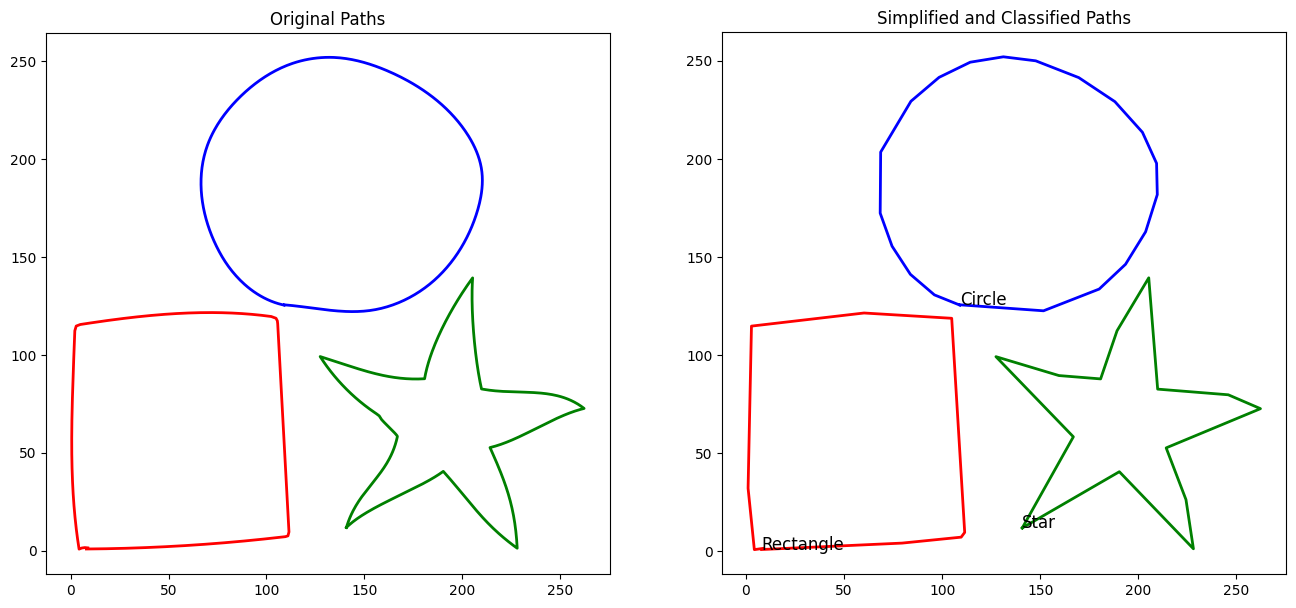

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from shapely.geometry import LineString
from scipy.spatial.distance import euclidean
import cv2
from scipy.optimize import minimize
from scipy.spatial import ConvexHull

# Function to read the CSV file and extract paths
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

# Ramer-Douglas-Peucker (RDP) Algorithm for curve simplification
def simplify_curve(points, tolerance=1.0):
    def rdp(points, epsilon):
        if len(points) < 3:
            return points
        dist = np.max(np.abs(np.cross(points[-1] - points[0], points[1:] - points[0]) / np.linalg.norm(points[-1] - points[0])))
        if dist < epsilon:
            return [points[0], points[-1]]
        idx = np.argmax(np.abs(np.cross(points[-1] - points[0], points[1:] - points[0]) / np.linalg.norm(points[-1] - points[0]))) + 1
        return rdp(points[:idx + 1], epsilon)[:-1] + rdp(points[idx:], epsilon)

    return np.array(rdp(points, tolerance))

#Detect straight line
def is_straight_line(points, tolerance=1e-6):
    line = LineString(points)
    return line.is_simple and line.length / euclidean(points[0], points[-1]) - 1 < tolerance

#Detect circle
def is_circle(points, tolerance=3.0):  # More stringent circle detection
    def calc_R(xc, yc):
        return np.sqrt((points[:, 0] - xc) ** 2 + (points[:, 1] - yc) ** 2)

    def f_2(c):
        Ri = calc_R(*c)
        return np.sum((Ri - Ri.mean()) ** 2)  # Sum of squared differences

    center_estimate = np.mean(points, axis=0)
    center = minimize(f_2, center_estimate).x
    radii = calc_R(*center)

    # Stringent condition for a circle
    if np.std(radii) < tolerance:
        return True
    return False

#Detect star
def is_star(curve, tolerance=0.02):
    """
    Determine if a curve forms a star shape.

    Parameters:
    curve (numpy array): 2D points to check.
    tolerance (float): Tolerance for approximating the curve (default: 0.02).

    Returns:
    bool: True if the curve forms a star shape, False otherwise.
    """
    # Ensure the curve is a numpy array
    curve = np.array(curve)

    # Reshape the curve to a single-channel array of 32-bit floating-point numbers
    curve = curve.reshape((-1, 1, 2)).astype(np.float32)

    peri = cv2.arcLength(curve, True)
    approx = cv2.approxPolyDP(curve, tolerance * peri, True)
    return len(approx) >= 5 and not is_convex(approx.reshape(-1, 2))  # Reshape to (n, 2)

def is_convex(points):
    """
    Check if a set of points forms a convex shape.

    Parameters:
    points (numpy array): 2D points to check.

    Returns:
    bool: True if the points form a convex shape, False otherwise.
    """
    n = len(points)
    sign = 0
    for i in range(n):
        dx1 = points[(i + 1) % n, 0] - points[i, 0]
        dy1 = points[(i + 1) % n, 1] - points[i, 1]
        dx2 = points[(i + 2) % n, 0] - points[(i + 1) % n, 0]
        dy2 = points[(i + 2) % n, 1] - points[(i + 1) % n, 1]
        zcross = dx1 * dy2 - dx2 * dy1
        if i == 0:
            sign = zcross
        elif zcross * sign < 0:
            return False
    return True



def is_ellipse(points, tolerance=0.1):
    """
    Checks if the provided points form an ellipse by fitting an ellipse and checking its properties.
    """
    # Fit an ellipse to the points
    if len(points) < 5:
        return False

    # Convert points to the format required by cv2
    points = points.astype(np.float32).reshape(-1, 1, 2)

    # Fit the ellipse
    ellipse = cv2.fitEllipse(points)

    # Extract ellipse parameters
    center, axes, angle = ellipse
    major_axis_length, minor_axis_length = max(axes), min(axes)

    # Aspect ratio check
    aspect_ratio = major_axis_length / minor_axis_length
    if aspect_ratio < 1.2:  # This threshold can be adjusted based on what you consider an ellipse
        return False

    # Check how well the points fit the ellipse using the mean squared error
    def ellipse_distance(point, center, axes, angle):
        x, y = point
        x0, y0 = center
        a, b = axes
        angle_rad = np.deg2rad(angle)
        x_rot = (x - x0) * np.cos(angle_rad) + (y - y0) * np.sin(angle_rad)
        y_rot = -(x - x0) * np.sin(angle_rad) + (y - y0) * np.cos(angle_rad)
        return (x_rot / a)**2 + (y_rot / b)**2

    distances = [ellipse_distance(pt, center, axes, angle) for pt in points[:, 0, :]]
    mean_distance = np.mean(distances)

    # If the mean distance is close to 1, the points are well-distributed around the ellipse
    if abs(mean_distance - 1) > tolerance:
        return False

    return True

#Detect rectangle
def is_rectangle(curve, tolerance=1e-6):
    peri = cv2.arcLength(curve.astype(np.float32), True)
    approx = cv2.approxPolyDP(curve.astype(np.float32), 0.02 * peri, True)

    if len(approx) == 4:  # Four vertices for a rectangle/square
        angles = []
        for i in range(4):
            pt1, pt2, pt3 = approx[i % 4][0], approx[(i + 1) % 4][0], approx[(i + 2) % 4][0]
            v1 = pt2 - pt1
            v2 = pt3 - pt2
            cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
            angles.append(np.arccos(cos_angle) * 180 / np.pi)

        if all(80 <= angle <= 100 for angle in angles):  # Check for right angles
            return True
    return False

#Detect polygon
def is_polygon(curve, tolerance=1e-6):
    peri = cv2.arcLength(curve.astype(np.float32), True)
    approx = cv2.approxPolyDP(curve.astype(np.float32), 0.02 * peri, True)
    return len(approx) >= 5  # Polygon with more than 5 sides


# Function to classify the shape
def classify_shape(points):
    if is_straight_line(points):
        return "Straight Line"
    elif is_circle(points):
        return "Circle"
    elif is_rectangle(points):
        return "Rectangle"
    elif is_ellipse(points):
        return "Ellipse"
    elif is_star(points):
        return "Star"
    elif is_polygon(points):
        return "Polygon"
    else:
        return "Unknown Shape"

# Function to visualize original and simplified paths along with shape classification
def plot_comparison_with_classification(original_paths, simplified_paths):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    # Plot original paths
    for i, XYs in enumerate(original_paths):
        color = colors[i % len(colors)]
        for XY in XYs:
            ax[0].plot(XY[:, 0], XY[:, 1], c=color, linewidth=2)

    ax[0].set_aspect('equal')
    ax[0].set_title('Original Paths')

    # Plot simplified paths with classification
    for i, XYs in enumerate(simplified_paths):
        color = colors[i % len(colors)]
        for XY in XYs:
            ax[1].plot(XY[:, 0], XY[:, 1], c=color, linewidth=2)
            shape_type = classify_shape(XY)
            ax[1].text(XY[0, 0], XY[0, 1], shape_type, fontsize=12)

    ax[1].set_aspect('equal')
    ax[1].set_title('Simplified and Classified Paths')

    plt.show()

# Example usage
csv_file_path = '/content/isolated.csv'  # Replace with your actual file path
shape_paths = read_csv(csv_file_path)

# Simplify each path using the RDP algorithm
simplified_shape_paths = []
for shape in shape_paths:
    simplified_shape = [simplify_curve(np.array(path), tolerance=2.0) for path in shape]
    simplified_shape_paths.append(simplified_shape)

# Visualize the original and simplified shapes with classification
plot_comparison_with_classification(shape_paths, simplified_shape_paths)